In [2]:
# Install necessary libraries
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install pycocotools
!pip install roboflow
!pip install tqdm

Looking in indexes: https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 9.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 3.6 MB/s eta 0:00:00


In [3]:
import os
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from roboflow import Roboflow

In [4]:
def prepare_faster_rcnn_model(train_dataset):
    # Determine device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load the pre-trained Faster R-CNN model with updated weights approach
    model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1)
    
    # Get number of classes
    num_classes = len(train_dataset.coco.getCatIds()) + 1  # +1 for background
    
    # Replace the box predictor with a new one matching the number of classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # Move model to device
    model.to(device)
    
    # Prepare optimizer and learning rate scheduler
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    
    return model, optimizer, lr_scheduler

In [5]:
def train_object_detection_model(model, train_loader, optimizer, device, epoch, print_freq=50):

    model.train()
    total_loss = 0.0
    
    for i, (images, targets) in enumerate(train_loader):
        # Skip if no valid images/targets
        if not images:
            continue
        
        # Move images to device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t[0].items()} for t in targets]
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        loss_dict = model(images, targets)
        
        # Compute total loss
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()
        
        # Backward pass and optimize
        losses.backward()
        optimizer.step()
        
        # Print loss
        if i % print_freq == 0:
            print(f"Epoch [{epoch}] Iteration [{i}/{len(train_loader)}]: Loss = {losses.item()}")
    
    # Print average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch}] Average Loss: {avg_loss}")

In [6]:
def custom_collate_fn(batch):
    """
    Custom collate function to handle COCO dataset preprocessing
    
    Args:
        batch (list): Batch of data from dataset
    
    Returns:
        tuple: Processed images and targets
    """
    images = [item[0] for item in batch]
    targets = []
    
    for item in batch:
        target = item[1]
        processed_target = []
        
        for t in target:
            # Ensure target is a dictionary
            if isinstance(t, list):
                t = t[0]
            
            # COCO format: [x, y, width, height]
            x, y, width, height = t['bbox']
            
            # Validate box dimensions
            if width > 0 and height > 0:
                processed_target.append({
                    'boxes': torch.tensor([[x, y, x + width, y + height]], dtype=torch.float32),
                    'labels': torch.tensor([t['category_id']], dtype=torch.int64)
                })
        
        targets.append(processed_target)
    
    return images, targets

In [7]:
def setup_object_detection_training(dataset_path, batch_size=8):
    """
    Setup object detection training with robust preprocessing
    
    Args:
        dataset_path (str): Path to the dataset
        batch_size (int): Batch size for training
    
    Returns:
        tuple: Configured train and validation data loaders
    """
    # Define custom transforms
    def get_transform():
        return T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    
    # Determine paths
    train_dir = os.path.join(dataset_path, "train")
    val_dir = os.path.join(dataset_path, "valid")
    
    # Load COCO datasets
    train_dataset = CocoDetection(
        root=train_dir, 
        annFile=os.path.join(train_dir, "_annotations.coco.json"), 
        transform=get_transform()
    )
    val_dataset = CocoDetection(
        root=val_dir, 
        annFile=os.path.join(val_dir, "_annotations.coco.json"), 
        transform=get_transform()
    )
    
    # Create data loaders with custom collate function
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=custom_collate_fn,
        drop_last=True  # Drop last batch if it's incomplete
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=custom_collate_fn,
        drop_last=True
    )
    
    return train_loader, val_loader

In [8]:
def main():
    # Roboflow API to import dataset
    rf = Roboflow(api_key="DAgmhMWiW4zEEdnNZxjE")
    project = rf.workspace("dylog-rxjz2").project("fod-brais")
    dataset = project.version(1).download("coco")
    
    # Setup data loaders
    train_loader, val_loader = setup_object_detection_training(dataset.location)
    
    # Prepare model
    model, optimizer, lr_scheduler = prepare_faster_rcnn_model(train_loader.dataset)
    
    # Determine device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        train_object_detection_model(model, train_loader, optimizer, device, epoch)
        lr_scheduler.step()
    
    # Save the model
    torch.save(model.state_dict(), "fasterrcnn_fod_detection.pth")
    print("Training completed!")


In [9]:
main()

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to FOD-1 in coco:: 100%|██████████| 10008/10008 [00:01<00:00, 7414.53it/s]


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 229MB/s] 


Epoch 1/10
Epoch [0] Iteration [0/937]: Loss = 3.5817642211914062
Epoch [0] Iteration [50/937]: Loss = 0.24366891384124756
Epoch [0] Iteration [100/937]: Loss = 0.2726811468601227
Epoch [0] Iteration [150/937]: Loss = 0.345476895570755
Epoch [0] Iteration [200/937]: Loss = 0.24553990364074707
Epoch [0] Iteration [250/937]: Loss = 0.2518153190612793
Epoch [0] Iteration [300/937]: Loss = 0.13623735308647156
Epoch [0] Iteration [350/937]: Loss = 0.26568669080734253
Epoch [0] Iteration [400/937]: Loss = 0.10006122291088104
Epoch [0] Iteration [450/937]: Loss = 0.19285471737384796
Epoch [0] Iteration [500/937]: Loss = 0.11509812623262405
Epoch [0] Iteration [550/937]: Loss = 0.1040915697813034
Epoch [0] Iteration [600/937]: Loss = 0.1266472339630127
Epoch [0] Iteration [650/937]: Loss = 0.1273285150527954
Epoch [0] Iteration [700/937]: Loss = 0.09150692820549011
Epoch [0] Iteration [750/937]: Loss = 0.09018170833587646
Epoch [0] Iteration [800/937]: Loss = 0.11309449374675751
Epoch [0] Iter

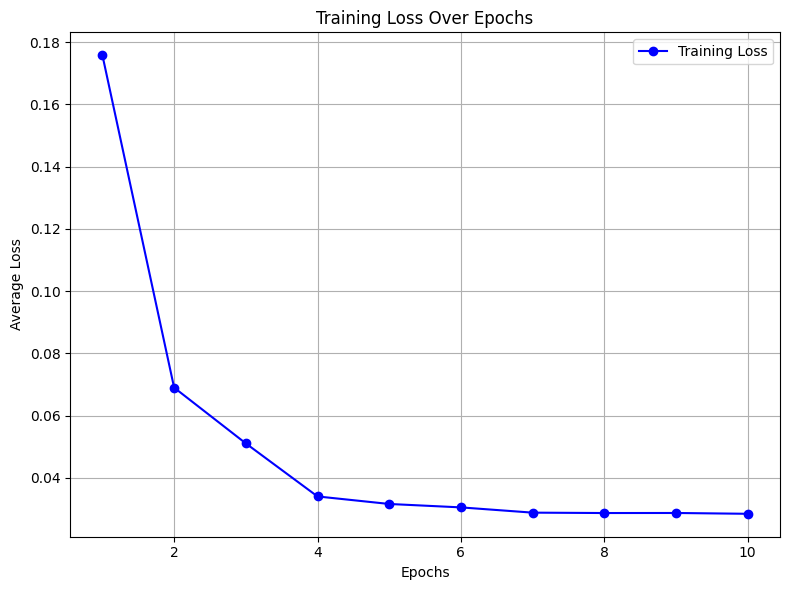

In [17]:
import matplotlib.pyplot as plt

# Example loss values per epoch
epochs = list(range(1, 11))  # 10 epochs
average_losses = [0.1757492841864472, 0.06901948561488373, 0.051108044225289195,
                  0.03407332232955489, 0.031657589209865354, 0.030558163967090903,
                  0.028870039808354165, 0.028746984930850143, 0.02876327384418332,
                  0.028501432666330418]  # Replace these values with your actual loss

# Plot the graph
plt.figure(figsize=(8, 6))
plt.plot(epochs, average_losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()


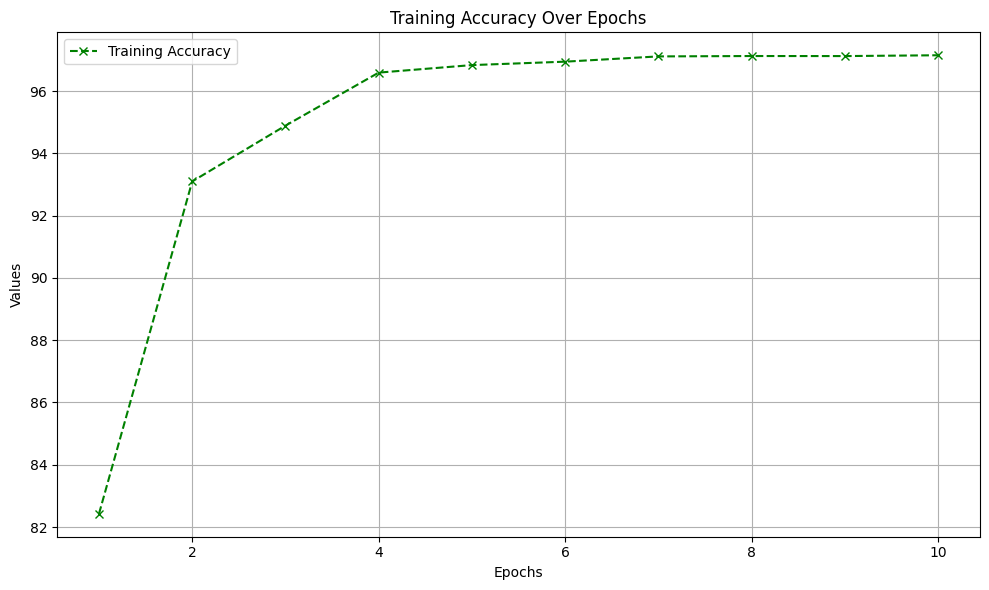

In [20]:
import matplotlib.pyplot as plt

# Example loss values per epoch
epochs = list(range(1, 11))  # 10 epochs
average_losses = [0.1757492841864472, 0.06901948561488373, 0.051108044225289195,
                  0.03407332232955489, 0.031657589209865354, 0.030558163967090903,
                  0.028870039808354165, 0.028746984930850143, 0.02876327384418332,
                  0.028501432666330418]  # Replace these values with your actual loss

# Calculate accuracy (1 - loss) * 100
accuracies = [(1 - loss) * 100 for loss in average_losses]

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracies, marker='x', linestyle='--', color='g', label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.title('Training Accuracy Over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()
